## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
import json
import sys
import seaborn as sns
import shutil

Check if directory where the model will be saved already exist:

In [2]:
models_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models'
model_dir = 'model_3a_w_augmentation'
checkpoint_path = os.path.join(models_path, model_dir)

# Check if dir where checkpoints are saved exist
if os.path.exists(checkpoint_path):
    msg = 'Warning! Directory {} already exist! Deleting...\n'.format(checkpoint_path)
    #logging.info(msg)
    print(msg)
    try:
        shutil.rmtree(checkpoint_path)
    except OSError as e:
        msg  = 'Dir {} could not be deleted!\n\nOSError: {}'.format(checkpoint_path, e)
        #logging.info(msg)
        print(msg)

msg = 'Creating dir: {}'.format(checkpoint_path)
#logging.info(msg)
print(msg)
os.makedirs(checkpoint_path, exist_ok=False)

Warning! Directory /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3a_w_augmentation already exist! Deleting...

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3a_w_augmentation


In [3]:
# Make tf to ignore GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#restrict GPU mem
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU Memory limited!')
except:
    print('It was not possible to limit GPU memory')

[]
It was not possible to limit GPU memory


## Load Preprocessing parameters and information:

In [4]:
# Preprocessed data path
pp_path = '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test'

with open(os.path.join(pp_path, 'params.json')) as pp_file:
    pp_params = json.load(pp_file)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as channel_file:
    channels = pd.read_csv(channel_file)

## Specify input channels

In [5]:
selected_channels = ['00_DAPI', 
                     '07_H2B', 
                     '01_CDK9_pT186', 
                     '03_CDK9', 
                     '05_GTF2B', 
                     '07_SETD1A', 
                     '08_H3K4me3', 
                     '09_SRRM2', 
                     '10_H3K27ac', 
                     '11_KPNA2_MAX', 
                     '12_RB1_pS807_S811', 
                     '13_PABPN1', 
                     '14_PCNA', 
                     '15_SON', 
                     '16_H3', 
                     '17_HDAC3', 
                     '19_KPNA1_MAX', 
                     '20_SP100', 
                     '21_NCL', 
                     '01_PABPC1', 
                     '02_CDK7', 
                     '03_RPS6', 
                     '05_Sm', 
                     '07_POLR2A', 
                     '09_CCNT1', 
                     '10_POL2RA_pS2', 
                     '11_PML', 
                     '12_YAP1', 
                     '13_POL2RA_pS5', 
                     '15_U2SNRNPB', 
                     '18_NONO', 
                     '20_ALYREF', 
                     '21_COIL', 
                     #'00_BG488', '00_BG568', '09_SRRM2_ILASTIK', '15_SON_ILASTIK'
                     ]
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)

## Load Dataset

In [6]:
# Path where tf datasets are
local_tf_datasets="/home/hhughes/Documents/Master_Thesis/Project/datasets/tensorflow_datasets"
dataset, metadata = tfds.load(
    'MPP_dataset', 
    data_dir=local_tf_datasets, 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=True,
    with_info=True)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

Show information about the dataset:

In [7]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset',
    version=1.0.1,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

input_channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [27]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)
    
    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images."""
    
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    k = np.random.randint(0,4)
    image = tf.image.rot90(image, k=k)
    
    return image, target

Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [9]:
def visualize_cell(image):
    plt.figure(figsize=(6,4))
    plt.title('Original Cell')
    plt.imshow(image.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    
    plt.figure(figsize=(15,4))
    for i in range(4):
        img, _ = augment(image, 0)
        plt.subplot(1,4,i+1)
        plt.title('Augmented Cell')
        plt.imshow(img.numpy()[:,:,10:13],
                   cmap=plt.cm.PiYG,
                   vmin=0, vmax=1)

In [10]:
# Get one image from the training dataset
image, _ = next(iter(train_data))

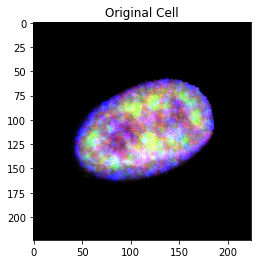

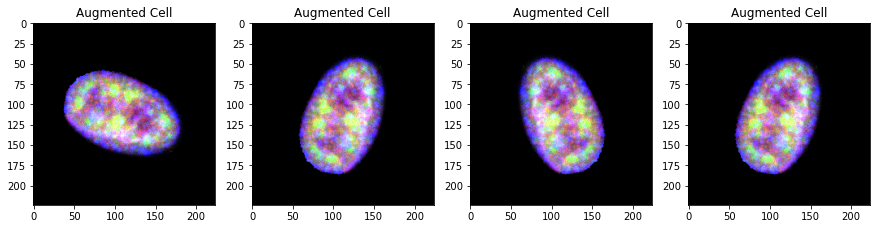

In [11]:
# Visualize the original vs. random flipping and rotations
visualize_cell(image)

Prepare datasets for training the CNN:

In [12]:
BATCH_SIZE = 32
buffer_size = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    # since cache keeps images in memory, not shure if this will somehow avoid augmentation
    #.cache()
    .shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    #.cache()
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    #.cache()
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## Model Creation


In [13]:
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 
                           padding='same',
                           input_shape=img_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(128, (3,3),
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(256, (3,3),
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
    
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              #loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mean_absolute_error']
              #metrics=['mse']
             )

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 128)     0

Set callback to save best model:

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+'/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
)

Train the model:

In [17]:
# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=50,
                    callbacks=[model_checkpoint_callback],
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )

Epoch 1/50
31/31 [==============================] - 164s 5s/step - loss: 96.6798 - mse: 32051.7441 - mean_absolute_error: 97.1790 - val_loss: 165.9793 - val_mse: 29827.6387 - val_mean_absolute_error: 166.4793
Epoch 2/50
31/31 [==============================] - 175s 6s/step - loss: 53.3481 - mse: 4485.8022 - mean_absolute_error: 53.8454 - val_loss: 147.4767 - val_mse: 23810.7051 - val_mean_absolute_error: 147.9767
Epoch 3/50
31/31 [==============================] - 177s 6s/step - loss: 39.9649 - mse: 2698.8542 - mean_absolute_error: 40.4609 - val_loss: 110.1232 - val_mse: 13890.7930 - val_mean_absolute_error: 110.6232
Epoch 4/50
31/31 [==============================] - 171s 6s/step - loss: 42.9108 - mse: 3008.0793 - mean_absolute_error: 43.4073 - val_loss: 114.7608 - val_mse: 14966.6318 - val_mean_absolute_error: 115.2608
Epoch 5/50
31/31 [==============================] - 199s 6s/step - loss: 38.1908 - mse: 2421.6531 - mean_absolute_error: 38.6870 - val_loss: 77.9823 - val_mse: 7629.91

In [28]:
# Save model
model.save(checkpoint_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3a_w_augmentation/assets


INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3a_w_augmentation/assets


In [29]:
# Load best weights
model.load_weights(checkpoint_path+'/checkpoint')

In [11]:
history.history.keys()

dict_keys(['loss', 'mse', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_mean_absolute_error'])

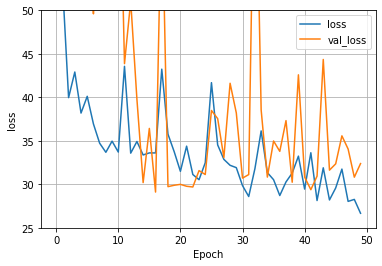

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    plt.ylim([25,50])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

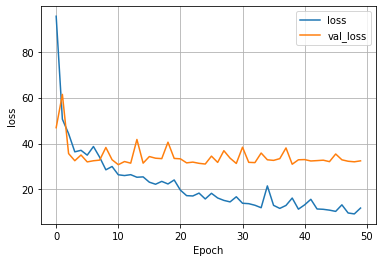

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

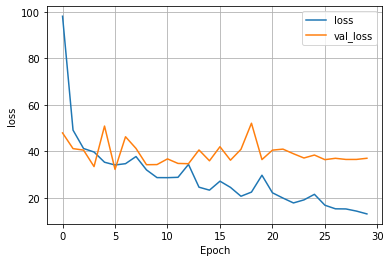

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

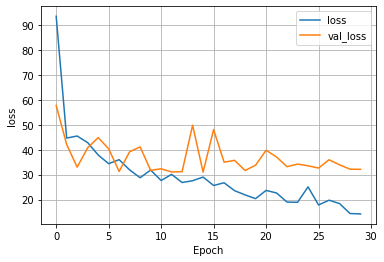

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

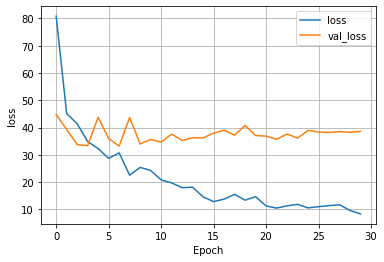

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

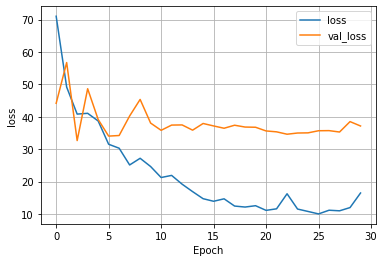

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

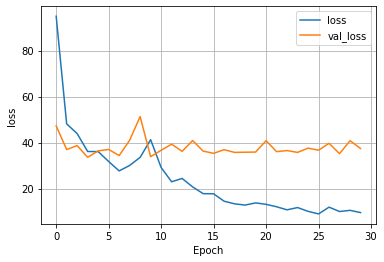

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

In [30]:
# Evaluate test model
#test_predictions = model.predict(test_data).flatten()

m_shape = tuple([1]+list(img_shape))

y_test = []
y_test_hat = []
for (cell_imgs, targets) in test_data:
    for i in range(cell_imgs.shape[0]):
        y_test.append(targets[i].numpy()[0])
        y_test_hat.append(model.predict(tf.reshape(cell_imgs[i], m_shape))[0][0])

y_test = np.asarray(y_test)
y_test_hat = np.asarray(y_test_hat)

In [112]:
y_test_hat[0:10]

array([373.60794, 320.50208, 423.0435 , 402.04913, 400.8737 , 356.51556,
       390.03174, 492.57736, 394.696  , 465.7501 ], dtype=float32)

In [110]:
y_test[0:10]

array([359.00033569, 323.97988892, 391.45001221, 346.92224121,
       335.66775513, 359.09152222, 439.95574951, 397.33496094,
       370.46682739, 422.35687256])

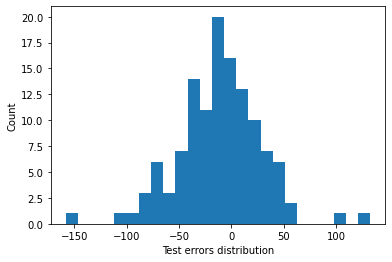

In [31]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

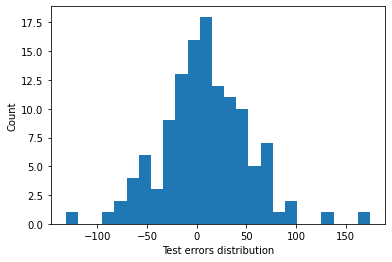

In [24]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

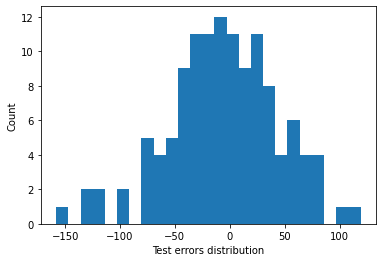

In [14]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

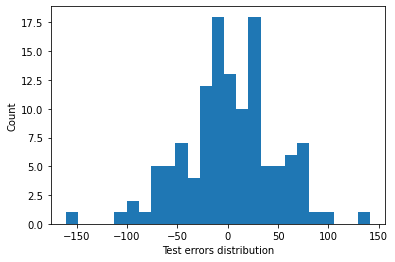

In [113]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

<AxesSubplot:xlabel='var', ylabel='values'>

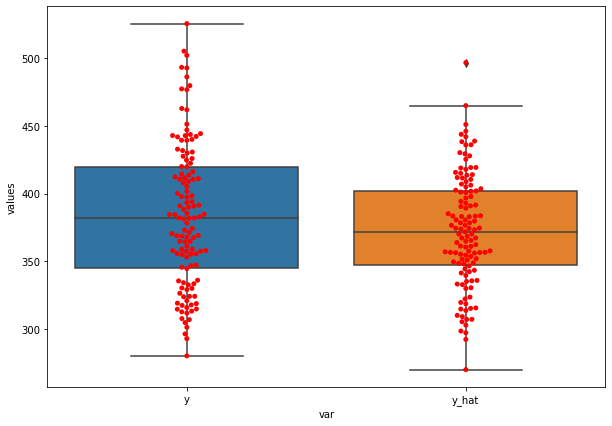

In [32]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))

sns.boxplot(y='values',
            x='var',
            data=temp)

sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)

<AxesSubplot:xlabel='var', ylabel='values'>

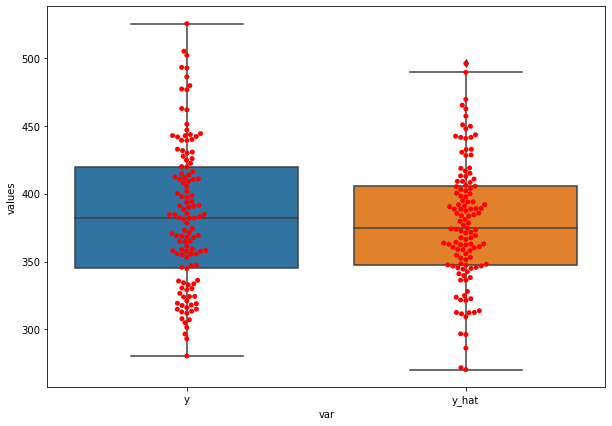

In [15]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))

sns.boxplot(y='values',
            x='var',
            data=temp)

sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)

<AxesSubplot:xlabel='var', ylabel='values'>

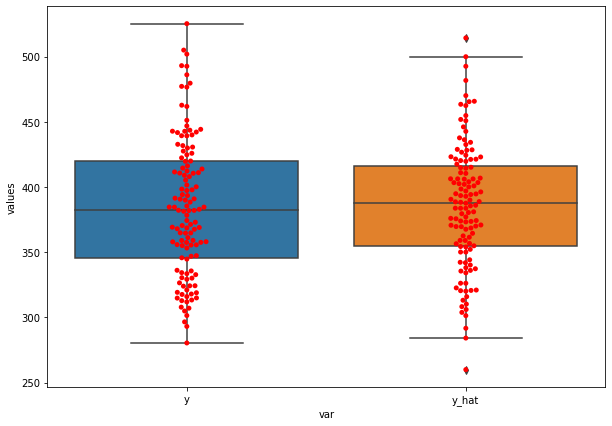

In [133]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))

sns.boxplot(y='values',
            x='var',
            data=temp)

sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)